In [2]:
import pandas as pd
import os
from functools import reduce

# --- 1. DEFINE FILE PATHS AND LOAD THE CLEANED CSVs ---
data_path = '../data/processed/timeseries_data/'

try:
    # Load each of your four final, consolidated CSV files
    gsdp_df = pd.read_csv(os.path.join(data_path, 'gsdp_data.csv'))
    deficit_df = pd.read_csv(os.path.join(data_path, 'fiscal_deficit_data.csv'))
    inflation_df = pd.read_csv(os.path.join(data_path, 'cpi_inflation_data.csv'))
    agri_df = pd.read_csv(os.path.join(data_path, 'agri_production_data.csv'))
    print("✅ All data files loaded successfully.")

except FileNotFoundError as e:
    print(f"Error: Make sure all four required CSV files (gsdp_data.csv, etc.) are in the '/data/processed/timeseries_data/' folder.")
    print(f"Missing file: {e.filename}")
    exit()

# --- 2. MERGE ALL DATAFRAMES INTO A MASTER TABLE ---
print("Merging all datasets into a master table...")

# Create a list of the dataframes to merge
dataframes_to_merge = [gsdp_df, deficit_df, inflation_df, agri_df]

# Use the 'reduce' function to iteratively merge all dataframes on 'State' and 'Year'
master_df = reduce(lambda left, right: pd.merge(left, right, on=['State', 'Year'], how='outer'), dataframes_to_merge)

# --- 3. FINAL CLEANING AND SORTING ---
print("Performing final cleaning and sorting...")

# Ensure 'Year' is an integer
master_df['Year'] = master_df['Year'].astype(int)

# Sort the data chronologically for each state
master_df.sort_values(by=['State', 'Year'], inplace=True)

# --- 4. SAVE AND PREVIEW THE FINAL DATASET ---
output_path = '../data/processed/final_forecasting_dataset.csv'
master_df.to_csv(output_path, index=False)

print(f"\n✅ Successfully created the final master table for forecasting!")
print(f"Saved to: {output_path}")
print("\n--- Preview of the Final Master Table ---")
print(master_df.head())
print("\n--- Last 5 rows of the final master table ---")
print(master_df.tail())

✅ All data files loaded successfully.
Merging all datasets into a master table...
Performing final cleaning and sorting...

✅ Successfully created the final master table for forecasting!
Saved to: ../data/processed/final_forecasting_dataset.csv

--- Preview of the Final Master Table ---
                       State  Year    GSDP  Fiscal_Deficit_Percent  \
0  Andaman & Nicobar Islands  2011  3921.0                     NaN   
1  Andaman & Nicobar Islands  2017  7162.0                     NaN   
2  Andaman & Nicobar Islands  2018  8023.0                     NaN   
3  Andaman & Nicobar Islands  2019  8767.0                     NaN   
4  Andaman & Nicobar Islands  2020  8249.0                     NaN   

   CPI_Inflation  Agri_Production_Thousand_Tonnes  
0            NaN                              NaN  
1            NaN                              NaN  
2            NaN                              NaN  
3            NaN                              NaN  
4            NaN               

In [3]:
import pandas as pd
from prophet import Prophet

# Load your final dataset
data_path = '../data/processed/final_forecasting_dataset.csv'
df = pd.read_csv(data_path)

# --- Select a state to forecast ---
# Let's choose Maharashtra as an example
state_df = df[df['State'] == 'Maharashtra'].copy()

# --- Prepare data for Prophet ---
# 1. Prophet requires the columns to be named 'ds' (for date/year) and 'y' (for the value to predict)
state_df.rename(columns={'Year': 'ds', 'GSDP': 'y'}, inplace=True)

# 2. Convert the 'ds' column to a proper datetime format
state_df['ds'] = pd.to_datetime(state_df['ds'], format='%Y')

# 3. Handle missing values - we'll use forward fill
# This carries the last known value forward, a common technique for time-series data
state_df.fillna(method='ffill', inplace=True)
# And backfill for any NaNs that might be at the very start
state_df.fillna(method='bfill', inplace=True)


# Display the prepared data
print("--- Prepared Data for Maharashtra ---")
print(state_df)

c:\economic_data_navigator\.venv-311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


--- Prepared Data for Maharashtra ---
           State         ds          y  Fiscal_Deficit_Percent  CPI_Inflation  \
139  Maharashtra 2011-01-01  1272370.0                     1.6            3.1   
140  Maharashtra 2017-01-01  2411439.0                     1.6            3.1   
141  Maharashtra 2018-01-01  2660332.0                     1.7            3.4   
142  Maharashtra 2019-01-01  2818137.0                     3.1            5.8   
143  Maharashtra 2020-01-01  2747015.0                     2.5            5.1   
144  Maharashtra 2021-01-01  3108022.0                     1.4            5.6   
145  Maharashtra 2022-01-01  3428294.0                     2.5            6.5   
146  Maharashtra 2023-01-01  3879077.0                     2.5            5.9   

     Agri_Production_Thousand_Tonnes  
139                          13874.8  
140                          13874.8  
141                          15084.7  
142                          16357.7  
143                          17144.3 

C:\Users\aryan\AppData\Local\Temp\ipykernel_5124\4121913519.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  state_df.fillna(method='ffill', inplace=True)
C:\Users\aryan\AppData\Local\Temp\ipykernel_5124\4121913519.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  state_df.fillna(method='bfill', inplace=True)


In [4]:
# --- Create and configure the Prophet model ---
model = Prophet(yearly_seasonality=True)

# --- Add your other datasets as features (regressors) ---
model.add_regressor('Fiscal_Deficit_Percent')
model.add_regressor('CPI_Inflation')
model.add_regressor('Agri_Production_Thousand_Tonnes')

# --- Train the model on your historical data ---
model.fit(state_df)

# --- Create a future dataframe to predict on ---
# Let's forecast for the next 3 years
future = model.make_future_dataframe(periods=3, freq='Y')

# To make a forecast, the model needs future values for the regressors.
# For this example, we'll just carry forward the last known value.
future['Fiscal_Deficit_Percent'] = state_df['Fiscal_Deficit_Percent'].iloc[-1]
future['CPI_Inflation'] = state_df['CPI_Inflation'].iloc[-1]
future['Agri_Production_Thousand_Tonnes'] = state_df['Agri_Production_Thousand_Tonnes'].iloc[-1]


# --- Make the prediction ---
forecast = model.predict(future)

# --- Display the forecast ---
print("\n--- GSDP Forecast for Maharashtra ---")
# 'yhat' is the predicted value
# 'yhat_lower' and 'yhat_upper' are the uncertainty intervals
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

22:52:00 - cmdstanpy - INFO - Chain [1] start processing
22:52:01 - cmdstanpy - INFO - Chain [1] done processing



--- GSDP Forecast for Maharashtra ---
           ds          yhat    yhat_lower    yhat_upper
6  2022-01-01  2.802039e+06  2.802039e+06  2.802039e+06
7  2023-01-01  3.878931e+06  3.878931e+06  3.878931e+06
8  2023-12-31  1.821655e+06  1.821004e+06  1.822261e+06
9  2024-12-31  4.916234e+06  4.913554e+06  4.918622e+06
10 2025-12-31  4.876714e+06  4.871179e+06  4.881845e+06


c:\economic_data_navigator\.venv-311\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


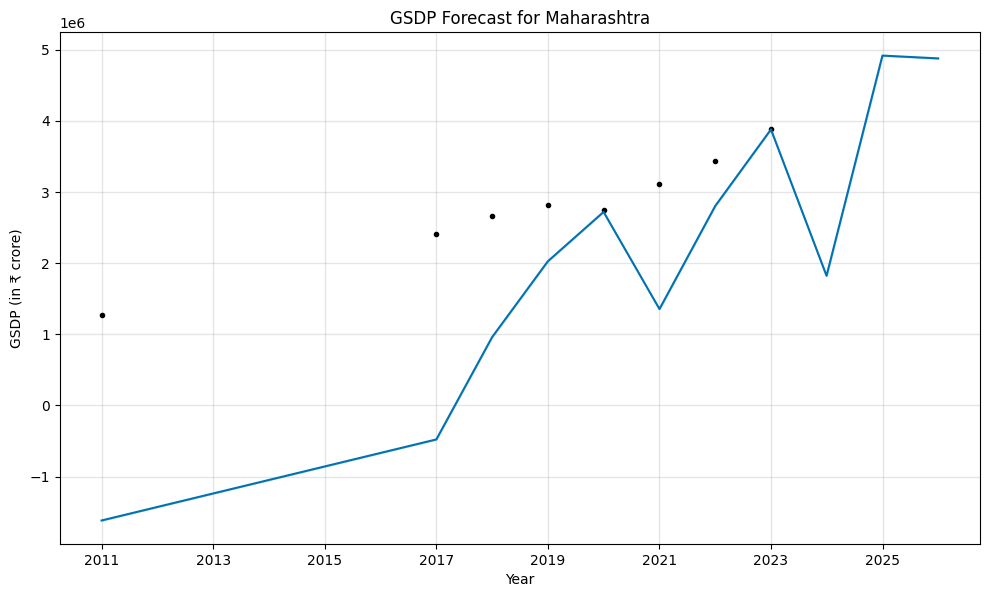

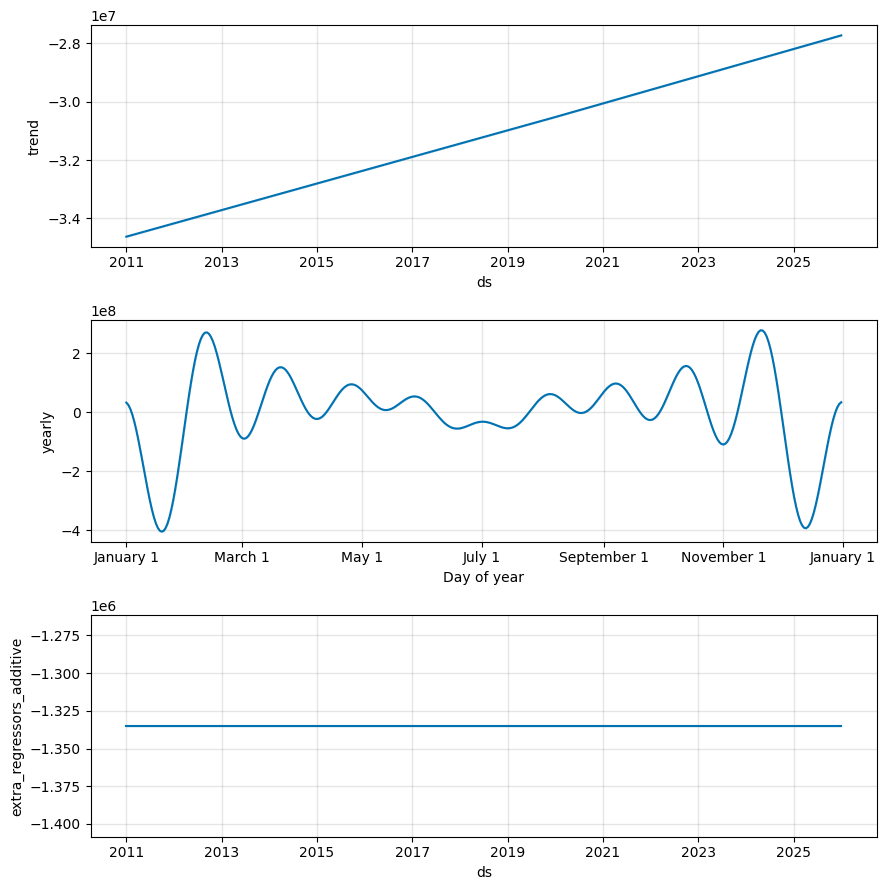

In [6]:
import matplotlib.pyplot as plt
# Plot the forecast
fig1 = model.plot(forecast)
plt.title("GSDP Forecast for Maharashtra")
plt.xlabel("Year")
plt.ylabel("GSDP (in ₹ crore)")
plt.show()

# Plot the components of the forecast (trend and seasonality)
fig2 = model.plot_components(forecast)
plt.show()